## questions I'm curious about

- am I listing to full albums?
- what decade do i listen to most?
- what are my most listened to genres?
- what are my most listened to albums?
- are songs I'm listening to on my playlists or in my library?
- can I tell someones mood that day based on what they are listening to?

## Info I want about every song

- Track ID
- Track Name
- Artists ID
- Artist Name
- Length Of Track
- Genres List of Track
- End Time of Stream
- Time of Stream
- % of Song Listened To
- Is Explicit
- Disc Number

## Things I've done so far

- Spotipy authorization and scope.
    - Scope defines what data you're allow to pull from that API request
    - I set environment variables of my client and secret needed for at least some authorization
    - Does all authorization require scope?
- Spotify Data Request
    - They only retain 1 years worth of streaming data
- 

## Plan of data pipeline

- 4 Tables
    - Ablum
    - Artist
    - Track
    - Stream
- Need new methods of auto updating each table
    - Read Old Tables
    - Archive Old CSVs
    - Find New Streams
    - Read recently played tracks
    - Check if track is already added

# Initialize

In [1]:
import requests
import json
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials,SpotifyOAuth
import pandas as pd
from datetime import date, datetime
import time
from dateutil import tz
import numpy as np
from matplotlib import pyplot as plt
import math

## Pick your auth version

Simply keeping track of authentication, may want to delete tho b/c not in use

user_id = 'brian.cross741'
auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)
#sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

## Spotify Terminal Class

Class that initiates a connection with the Spotify API.

Has function that can make calls to the API and return the full response

In [2]:
class spotify_terminal:

    def __init__(self):
        AUTH_URL = 'https://accounts.spotify.com/api/token'
        
        # POST
        auth_response = requests.post(AUTH_URL, {
            'grant_type': 'client_credentials',
            'client_id': os.getenv('SPOTIPY_CLIENT_ID'),
            'client_secret': os.getenv('SPOTIPY_CLIENT_SECRET'),
        })
        
        # convert the response to JSON
        auth_response_data = auth_response.json()
        
        # save the access token
        access_token = auth_response_data['access_token']
        
        self.headers = {
            'Authorization': 'Bearer {token}'.format(token=access_token)
        }
        self.init_timestamp = datetime.now().strftime("%Y%m%d_%H_%M_%S")
        self.BASE_URL = 'https://api.spotify.com/v1/'
    
    def __repr__(self):
        return 'initialized at: {}'.format(self.init_timestamp)

    # def tracks(self, id):
    #     # turn a list of IDs into a string for the API
    #     if type(id) == list:
    #         id = '?ids='+'%2C'.join(id)
    #     else:
    #         id = '/' + id
            
    #     # actual GET request with proper header
    #     r = requests.get(self.BASE_URL + 'tracks' + id, headers=headers)
    #     # r.status_code
    #     return r

    def call_api(self, id, endpoint):
        # turn a list of IDs into a string for the API
        if type(id) == list:
            id = '?ids='+'%2C'.join(id)
        else:
            id = '/' + id
            
        # actual GET request with proper header
        r = requests.get(self.BASE_URL + endpoint + id, headers=self.headers)
        # r.status_code
        return r


## Basic Functions

In [3]:
# opens json files provided by spotify data retreival
def get_json_from_file(json_file):
    f = open(json_file, encoding="utf8")
    data = json.load(f)
    f.close()
    return data

# # searches for any string and returns the artist_id for the top response item
# def search_for_artist_id(name):
#     result = sp.search(name)
#     id = result['tracks']['items'][0]['artists'][0]['id']
#     return id

# # searches for any string and returns the track_id for the top response item
# def search_for_track_id(name):
#     result = sp.search(name)
#     id = result['tracks']['items'][0]['id']
#     return id

# searches for any string and returns the track_id for the top response item
# def search_for_track(track_name=None, artist_name=None):
#     search_result = sp.search(q='track:{} artist:{}'.format(track_name,artist_name), type='track')
#     subset = parse_track_result(search_result['tracks']['items'][0])    
#     return subset


def parse_episode_result(item):
    subset = dict((k, item[k]) for k in ('id', 'name', 'duration_ms', 'explicit', 'type'))
    return subset

def search_for_track(track_name=None, artist_name=None):
    try:
        search_result = sp.search(q='''track:{} artist:{}'''.format(track_name,artist_name), type='track')
        subset = parse_track_result(search_result['tracks']['items'][0])
    except:
        try:
            search_result = sp.search(q='''episode:{}'''.format(track_name), type='episode')
            subset = parse_episode_result(search_result['episodes']['items'][0])
            subset['artist_name'] = artist_name
        except:
            subset = {'artist_name':artist_name, 'track_name':track_name}
    return subset



def get_artist_data(id):
    result = sp.artist(id)
    subset = dict((k, result[k]) for k in ('id', 'name', 'genres', 'popularity'))
    subset['followers'] = result['followers']['total']
    return subset

def get_track_data(id):
    result = sp.track(id)
    subset = dict((k, result[k]) for k in ('id', 'name', 'duration_ms', 'popularity', 'disc_number', 'track_number', 'explicit', 'type'))
    subset['album_id'] = result['album']['id']
    subset['artist_id'] = result['artists'][0]['id']
    subset['artist_count'] = len(result['artists'])
    return subset

def get_album_data(id):
    result = sp.album(id)
    subset = dict((k, result[k]) for k in ('id', 'name', 'album_type', 'release_date', 'release_date_precision', 'popularity', 'total_tracks', 'genres', 'label', 'type'))
    return subset
    

## Recently Played Functions

In [4]:

###
# opens all the recently palyed files and finds the most recent timestamp, converting it to local time
# returns unix timestamp and a datetime for the most recently played track in the logs
###
def get_most_recent_timestamp():
    # folder containing saved files of recently played
    path = 'recently_played/'
    recently_played_files = os.listdir(path)

    total_max_played = ''
    total_max_played_unix = 0
    for i in recently_played_files:
        current_max_played = pd.read_csv(path+i)['played_at'].max()
        utc = datetime.strptime(current_max_played, "%Y-%m-%dT%H:%M:%S.%fZ")
        current_max_played_unix = int(time.mktime(utc.timetuple())*1000)
    
        if current_max_played_unix > total_max_played_unix:
            total_max_played_unix = current_max_played_unix
            total_max_played = utc
    
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    total_max_played = total_max_played.replace(tzinfo=from_zone)
    local_total_max_played = total_max_played.astimezone(to_zone)
    local_total_max_played_unix = int(time.mktime(local_total_max_played.timetuple())*1000)
    return local_total_max_played_unix, local_total_max_played

###
# runs through the results of recently played and flattens the dictionary
# returns a cleaned dictionary of recently played
###
def parse_track_result(item):
    try:
        result = item['track']
    except:
        result = item
    subset = dict((k, result[k]) for k in ('id', 'name', 'duration_ms', 'popularity', 'disc_number', 'track_number', 'explicit', 'type'))
    subset['album_id'] = result['album']['id']
    subset['artist_id'] = result['artists'][0]['id']
    subset['artist_count'] = len(result['artists'])
    try:
        subset['context'] = item['context']['uri']
    except:
        pass
    try:
        subset['played_at'] = item['played_at']
    except:
        pass
    return subset

###
# intakes either None or a unix timestamp which will call all records occurring after it
# returns a cleaned dictionary of recently played
###
def call_recently_played(after_timestamp_unix):
    # set permissions, the scope is needed for the API to be allowed to grab this data.
    scope = "user-read-recently-played"
    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
    
    # call spotify
    recently_played = sp.current_user_recently_played(limit=50, after=after_timestamp_unix)

    # parse data and return a shorter, flattened dictionary with track data
    recently_played_short = []
    for i in recently_played['items']:
        subset = parse_track_result(i)
        recently_played_short.append(subset)
    return recently_played_short

###
# runs through the recently played directory, finds the most recent timestamp, and calls recently played for the new, unsaved records
# returns a cleaned dataframe of non-recorded recently played
###
def get_new_recently_played():
    after_timestamp = get_most_recent_timestamp()[0]
    recently_played = call_recently_played(after_timestamp+1000)
    df = pd.DataFrame(data=recently_played)
    return df

###
# intakes a dataframe and savesit as a log in the recently played folder
# tells you the timestamp used to save
###
def save_new_recently_played(df):
    dt_string = datetime.now().strftime("%Y%m%d_%H_%M_%S")
    if len(df) > 0:
        df.to_csv(f'recently_played/recently_played_{dt_string}.csv', index=False)
        print('saved file: {}'.format(dt_string))

### Save Recently Played

get_most_recent_timestamp()

scope = "user-read-recently-played"
# scope = 'user-read-playback-state'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
recently_played = sp.current_user_recently_played(limit=50)#, after=get_most_recent_timestamp()[0]+10000)

In [5]:
new_recently_played = get_new_recently_played()

In [6]:
len(new_recently_played)

23

In [7]:
new_recently_played.head()

,id,name,duration_ms,popularity,disc_number,track_number,explicit,type,album_id,artist_id,artist_count,context,played_at
0,0DVHR5FQ0Gp2dsZJz7hfdy,This Cocaine Makes Me Feel Like I'm On This Song,128240,60,1,6,False,track,0cn6MHyx4YuZauaB7Pb66o,5eAWCfyUhZtHHtBdNk56l1,1,spotify:album:0cn6MHyx4YuZauaB7Pb66o,2023-11-20T20:30:05.202Z
1,41pOIT2t1rvr2Trg1HQChZ,Radio/Video,249226,69,1,5,False,track,0cn6MHyx4YuZauaB7Pb66o,5eAWCfyUhZtHHtBdNk56l1,1,spotify:album:0cn6MHyx4YuZauaB7Pb66o,2023-11-20T20:27:57.005Z
2,47EqCQZG5v4o0WFMufGf5S,Cigaro,131706,71,1,4,True,track,0cn6MHyx4YuZauaB7Pb66o,5eAWCfyUhZtHHtBdNk56l1,1,spotify:album:0cn6MHyx4YuZauaB7Pb66o,2023-11-20T20:23:48.055Z
3,577mOFb1LAvSANIUZ4mbQ7,Revenga,228026,62,1,3,False,track,0cn6MHyx4YuZauaB7Pb66o,5eAWCfyUhZtHHtBdNk56l1,1,spotify:album:0cn6MHyx4YuZauaB7Pb66o,2023-11-20T20:21:36.048Z
4,0EYOdF5FCkgOJJla8DI2Md,B.Y.O.B.,255466,79,1,2,True,track,0cn6MHyx4YuZauaB7Pb66o,5eAWCfyUhZtHHtBdNk56l1,1,spotify:album:0cn6MHyx4YuZauaB7Pb66o,2023-11-20T20:17:48.038Z


In [8]:
save_new_recently_played(new_recently_played)

saved file: 20231121_07_17_16


# Updatinator

### Need 2 different things
- Something to check if everything is up to date
    - Intakes a list of track IDs
    - Check against current track table
    - Returns what does not exist
- Something to get updates in the case that I am missing data.

## ALL STREAMS

In [18]:
stream_df = pd.read_csv('searched_history/streaming_history_tracks.csv')

path = "recently_played"
dir_list = os.listdir(path)

for i in dir_list:
    read_file = pd.read_csv(path+'/'+i)
    stream_df = pd.concat([stream_df,read_file])

#stream_df['played_at'].max()

In [19]:
stream_data_table = stream_df[['id','name','duration_ms','played_at','context','album_id','artist_id']]

stream_data_table.to_csv('data_tables/csv/streams.csv',index=False)

## ALL TRACKS

In [20]:
track_data_table = stream_df.copy()
track_data_table = track_data_table.drop('artist_name',axis=1)
track_data_table = track_data_table.drop('track_name',axis=1)

In [21]:
track_data_table = stream_df.groupby(['id','name','disc_number','track_number','explicit','type','album_id','artist_id','artist_count'], as_index=False)['popularity'].max()

In [22]:
track_data_table.to_csv('data_tables/csv/tracks.csv',index=False)

##Check and Update Missing Records

In [27]:
def get_new_table_data(search_list, table_type):
    # table_type can be ['artists','albums','tracks']
    if table_type == 'artists' or table_type == 'tracks':
        list_fraction = math.ceil(len(search_list) / 50)
    elif table_type == 'albums':
        list_fraction = math.ceil(len(search_list) / 20)
    sp = spotify_terminal()
    iteration = 0
    final = []
    
    for search_list_group in np.array_split(search_list, list_fraction):
        search_list_group = search_list_group.tolist()
        
        #CALL OPERATION
        result = sp.call_api(search_list_group, table_type)
        if result.status_code != 200:
            print('bad call on iteration: {}'.format(iteration))
            print('    status code: {}'.format(result.status_code))
            break
        final.extend(result.json()[table_type])
        iteration += 1
    return final

def append_new_table_data(save_list, table_type):
    folder_path = 'data_tables/'
    if table_type == 'artists':
        path = folder_path + 'artist_data.json'
    # elif table_type == 'tracks':
    #     list_fraction = math.ceil(len(search_list) / 50)
    elif table_type == 'albums':
        path = folder_path + 'album_data.json'
        
    # Opening FULL JSON file
    with open(path, 'r') as openfile:
        # Reading from json file
        json_object = json.load(openfile)

    # Appending new JSON data
    json_object[table_type].extend(save_list)

    # Narrowing JSON data
    subset_list = []
    if table_type == 'artists':
        for i in json_object['artists']:
            # Genre Handling
            i['genre_count'] = len(i['genres'])
            # create fields for the top 5 genres
            i['genre_1']=''
            i['genre_2']=''
            i['genre_3']=''
            i['genre_4']=''
            i['genre_5']=''
            if len(i['genres']) > 4:
                i['genre_5'] = i['genres'][4]
            if len(i['genres']) > 3:
                i['genre_4'] = i['genres'][3]
            if len(i['genres']) > 2:
                i['genre_3'] = i['genres'][2]
            if len(i['genres']) > 1:
                i['genre_2'] = i['genres'][1]
            if len(i['genres']) > 0:
                i['genre_1'] = i['genres'][0]
            
            subset = dict((k, i[k]) for k in ('id','name','popularity','genre_count','genre_1','genre_2','genre_3','genre_4','genre_5'))
            subset['followers'] = i['followers']['total']
            subset_list.append(subset)

    elif table_type == 'albums':
        for i in json_object['albums']:
            subset = dict((k, i[k]) for k in ('id', 'name', 'album_type', 'release_date', 'release_date_precision', 'popularity', 'total_tracks', 'genres', 'label', 'type'))
            subset_list.append(subset)

    short_final = pd.DataFrame(data=subset_list)
    
    # Formatting FULL JSON for Export 
    json_final = json.dumps(json_object, indent=4)
    # Saving with new JSON data
    with open(path, 'w') as outfile:
        outfile.write(json_final)
    # Saving Narrow CSV data
    short_final.to_csv('{}csv/{}.csv'.format(folder_path, table_type), index=False)

def dedupe_json_id(table_type):
    folder_path = 'data_tables/'
    if table_type == 'artists':
        path = folder_path + 'artist_data.json'
    elif table_type == 'albums':
        path = folder_path + 'album_data.json'
    # Opening FULL JSON file
    with open(path, 'r') as openfile:
        # Reading from json file
        json_object = json.load(openfile)
    
    unique = list({ each['id'] : each for each in json_object[table_type] }.values())
    
    new_unique_dict = {table_type:unique}
    json_final = json.dumps(new_unique_dict, indent=4)
    with open(path, 'w') as outfile:
        outfile.write(json_final)

In [23]:
streams = pd.read_csv('data_tables/csv/streams.csv')
tracks = pd.read_csv('data_tables/csv/tracks.csv')
albums = pd.read_csv('data_tables/csv/albums.csv')
artists = pd.read_csv('data_tables/csv/artists.csv')

In [24]:
missing_tracks = set(streams['id']) - set(tracks['id'])
missing_albums = set(streams['album_id']) - set(albums['id'])
missing_artists = set(streams['artist_id']) - set(artists['id'])

In [25]:
print('missing tracks:',len(missing_tracks))
print('missing albums:',len(missing_albums))
print('missing artists:',len(missing_artists))

missing tracks: 0
missing albums: 1
missing artists: 0


In [18]:
new_artist_data = get_new_table_data(list(missing_artists), 'artists')
append_new_table_data(new_artist_data,'artists')

In [28]:
new_album_data = get_new_table_data(list(missing_albums), 'albums')
append_new_table_data(new_album_data,'albums')

### In case you need to dedupe the jsons

dedupe_json_id('artists')
dedupe_json_id('albums')

In [28]:
list(artists)

['id',
 'name',
 'popularity',
 'genre_count',
 'genre_1',
 'genre_2',
 'genre_3',
 'genre_4',
 'genre_5',
 'followers']

In [30]:
artists.head()

,id,name,popularity,genre_count,genre_1,genre_2,genre_3,genre_4,genre_5,followers
0,7EF6zIKi6Qb6Ky3Y9GSsxW,Vapourse,32,1,rain,NaN,NaN,NaN,NaN,80
1,1QxXQCVzes3IC2zMLSGOQR,Devika Arkes,46,1,rain,NaN,NaN,NaN,NaN,58
2,2rujgIBrLOHJ64leeafdmz,LBE Nature Recordings,49,3,color noise,ocean,rain,NaN,NaN,445
3,4xE3NbWDeC7BEIlzQIjG5H,Nature Recordings,52,2,rain,sound,NaN,NaN,NaN,898
4,3bkZdtFCw7NEPaNOBTHIjn,Worrysome Skies,43,1,rain,NaN,NaN,NaN,NaN,39


# SQL

In [2]:
password = getpass()

conn = psycopg2.connect(database = "music_hub",
                        user = "postgres",
                        password = password,
                        host = "localhost",
                        port = "5432")

 ········


In [3]:
cur = conn.cursor()
cur.execute('SELECT * FROM streams;')
rows = cur.fetchall()
cur.close()
for row in rows:
    print(row)

In [ ]:
cur = conn.cursor()

for i in range(0,len(df)):
    cur.execute("INSERT INTO stock_market_forecasting_new (date, open, high, low, close) \
      VALUES (df['date'][i], df['open'][i], df['high'][i], df['low'][i], df['close'][i])")

conn.commit()
print("Records created successfully")
conn.close()

In [4]:
conn.close()

# Expand Streaming Data

In [131]:
# search_result = sp.search(q='episode:{}'.format('MBMBaM 624: Reince Your Own Priebus'), type='episode')

In [5]:
streaming_data = get_json_from_file('MyData/StreamingHistory0.json')

In [6]:
len(streaming_data)

7886

In [7]:
streaming_data

[{'endTime': '2022-08-27 22:36',
  'artistName': 'Dopapod',
  'trackName': 'Present Ghosts',
  'msPlayed': 35060},
 {'endTime': '2022-08-28 22:09',
  'artistName': 'My Brother, My Brother And Me',
  'trackName': 'MBMBaM 624: Reince Your Own Priebus',
  'msPlayed': 812280},
 {'endTime': '2022-08-28 22:09',
  'artistName': 'Jaimie Branch',
  'trackName': 'Jump Off',
  'msPlayed': 2089},
 {'endTime': '2022-08-28 22:09',
  'artistName': 'Dopapod',
  'trackName': 'Present Ghosts',
  'msPlayed': 13631},
 {'endTime': '2022-08-28 22:15',
  'artistName': 'Jaimie Branch',
  'trackName': 'Leaves of Glass',
  'msPlayed': 39979},
 {'endTime': '2022-08-28 22:15',
  'artistName': 'Jaimie Branch',
  'trackName': 'Theme 002',
  'msPlayed': 320440},
 {'endTime': '2022-08-28 22:20',
  'artistName': 'Grateful Dead',
  'trackName': 'Box of Rain - 2001 Remaster',
  'msPlayed': 317440},
 {'endTime': '2022-08-28 22:23',
  'artistName': 'Allman Brothers Band',
  'trackName': "Ramblin' Man",
  'msPlayed': 510},

### Searching to expand downloaded streaming data

In [181]:
# honestly this is really sloppy and the iterating and saving part should be overhauled.

result_list = []
iteration = 5000
start = datetime.now()
for track in streaming_data[5000:]:
    iteration += 1
    artist_name = track['artistName']
    track_name = track['trackName']
    end_time = track['endTime']
    ms_played = track['msPlayed']

    # search spotify using the track and artist name
    result = search_for_track(track_name=track_name, artist_name=artist_name)
    result['duration_ms'] = ms_played
    result['played_at'] = end_time
    result_list.append(result)
    if iteration % 500 == 0:
        print('saving {}'.format(iteration))
        df_streaming_data = pd.DataFrame(data=result_list)
        df_streaming_data.to_csv('searched_history/raw_searches/streaming_data_searched_{}.csv'.format(iteration+1))
    else:
        pass
end = datetime.now()
print(end - start)
df_streaming_data = pd.DataFrame(data=result_list)
df_streaming_data.to_csv('searched_history/raw_searches/streaming_data_searched_{}.csv'.format(iteration+1))

saving 5500
saving 6000
saving 6500
saving 7000
saving 7500
0:13:28.306981


### Combining streaming data files into on

In [196]:
path = "searched_history"
dir_list = os.listdir(path)
print(dir_list)

stream_df = pd.DataFrame()

for i in dir_list:
    read_file = pd.read_csv(path+'/'+i)
    read_file.drop('Unnamed: 0',axis=1,inplace=True)
    stream_df = pd.concat([stream_df,read_file])
stream_df.drop_duplicates(inplace=True)

['streaming_data_searched_1000.csv', 'streaming_data_searched_1500.csv', 'streaming_data_searched_2000.csv', 'streaming_data_searched_2500.csv', 'streaming_data_searched_3000.csv', 'streaming_data_searched_3500.csv', 'streaming_data_searched_4000.csv', 'streaming_data_searched_4500.csv', 'streaming_data_searched_500.csv', 'streaming_data_searched_5000.csv', 'streaming_data_searched_5501.csv', 'streaming_data_searched_6001.csv', 'streaming_data_searched_6501.csv', 'streaming_data_searched_7001.csv', 'streaming_data_searched_7501.csv', 'streaming_data_searched_7887.csv']


In [211]:
stream_tracks = stream_df[stream_df['type'] == 'track']
stream_episodes = stream_df[stream_df['type'] == 'episode']
stream_errors = stream_df[stream_df['type'].isnull()]

In [214]:
stream_tracks.to_csv('searched_history/streaming_history_tracks.csv',index=False)
stream_episodes.to_csv('searched_history/streaming_history_episodes.csv',index=False)
stream_errors.to_csv('searched_history/streaming_history_errors.csv',index=False)

# Expand Data Tables

### Read All Streaming Data

In [13]:
stream_history = pd.read_csv('searched_history/streaming_history_tracks.csv')
stream_history.drop(['artist_name','track_name'],axis=1,inplace=True)
stream_history['source'] = 'Data Request'

In [14]:
# Get the list of all files and directories
path = "recently_played/"
spotify_file_list = os.listdir(path)

# prints all files
stream_recent = pd.DataFrame()
for i in spotify_file_list:
    temp = pd.read_csv(path+i)
    stream_recent = pd.concat([temp, stream_recent], ignore_index=True)
stream_recent['source'] = 'Recently Played'

In [15]:
stream = pd.concat([stream_history, stream_recent], ignore_index=True)

In [16]:
stream.head()

,id,name,duration_ms,popularity,disc_number,track_number,explicit,type,album_id,artist_id,artist_count,played_at,source,context
0,4mJnhL0Wxk8S1H3sKKeI5Q,Hybrid Clouds,115914,53.0,1.0,1.0,False,track,534t88l34yw4XIjPgO45Wf,7EF6zIKi6Qb6Ky3Y9GSsxW,1.0,2022-09-25 10:28,Data Request,NaN
1,3bNmDdrA65YYjaNJ4fJm7k,Cool Turbulence Rain,124830,66.0,1.0,2.0,False,track,3XsdDkAezeXlQaCNwMUJgD,1QxXQCVzes3IC2zMLSGOQR,1.0,2022-09-25 10:30,Data Request,NaN
2,3x1njiYHSttnMf3dLIVpAb,Cosy Morning Rain,100000,55.0,1.0,2.0,False,track,6cxTguNqoApoXfmUUOPYb6,2rujgIBrLOHJ64leeafdmz,1.0,2022-09-25 10:31,Data Request,NaN
3,2xNMAGNaV3UCAPFbxG7T6W,Recordings of Rainfall,131000,62.0,1.0,4.0,False,track,2Be1a696TMJVycuCb9gzIV,4xE3NbWDeC7BEIlzQIjG5H,1.0,2022-09-25 10:33,Data Request,NaN
4,7GquG0EVY3NBr0sQmhwc1I,That's Real Intense,121000,64.0,1.0,2.0,False,track,3ZK1PT3Q5D1cwXDIEeKp2R,3bkZdtFCw7NEPaNOBTHIjn,1.0,2022-09-25 10:35,Data Request,NaN


In [17]:
stream.to_csv('data_tables/stream_data.csv',index=False)

### Get Artist Data

In [19]:
artists = stream['artist_id'].drop_duplicates().values.tolist()

In [111]:
import numpy as np
import math

list_fraction = math.ceil(len(artists) / 50)

sp = spotify_terminal()

iteration = 0

final = {'artists': []}

for artist_group in np.array_split(artists, list_fraction):
    artist_group = artist_group.tolist()
    result = sp.call_api(artist_group,'artists')
    if result.status_code != 200:
        print('bad call on iteration: {}'.format(iteration))
        print('    status code: {}'.format(result.status_code))
        break
    final['artists'].extend(result.json()['artists'])
    print(iteration)
    iteration += 1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [117]:
json_object = json.dumps(final, indent=4)
with open("data_tables/artist_data.json", "w") as outfile:
    outfile.write(json_object)

### Get Album Data

In [118]:
albums = stream['album_id'].drop_duplicates().values.tolist()

In [120]:
len(albums)

2460

In [126]:
import numpy as np
import math

list_fraction = math.ceil(len(albums) / 20)

sp = spotify_terminal()

iteration = 0

final = {'albums': []}

for album_group in np.array_split(albums, list_fraction):
    album_group = album_group.tolist()
    result = sp.call_api(album_group,'albums')
    if result.status_code != 200:
        print('bad call on iteration: {}'.format(iteration))
        print('    status code: {}'.format(result.status_code))
        break
    final['albums'].extend(result.json()['albums'])
    print(iteration)
    iteration += 1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


In [128]:
json_object = json.dumps(final, indent=4)
with open("data_tables/album_data.json", "w") as outfile:
    outfile.write(json_object)

## Shorten Data Tables

### Shorten Artists

In [11]:
# Opening JSON file
with open('data_tables/artist_data.json', 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)

In [27]:
subset_list = []
for i in json_object['artists']:
    subset = dict((k, i[k]) for k in ('id', 'name', 'genres', 'popularity'))
    subset['followers'] = i['followers']['total']
    subset_list.append(subset)
final = {'artists':subset_list}

In [30]:
json_object = json.dumps(final, indent=4)
with open("data_tables/artist_data_short.json", "w") as outfile:
    outfile.write(json_object)

### Shorten Albums

In [14]:
# Opening JSON file
with open('data_tables/album_data.json', 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)

In [21]:
subset_list = []
for i in json_object['albums']:
    subset = dict((k, i[k]) for k in ('id', 'name', 'album_type', 'release_date', 'release_date_precision', 'popularity', 'total_tracks', 'genres', 'label', 'type'))
    subset_list.append(subset)
final = {'albums':subset_list}

In [24]:
json_object = json.dumps(final, indent=4)
with open("data_tables/album_data_short.json", "w") as outfile:
    outfile.write(json_object)

## Genre Handling

### Clean Artist Genres

In [70]:
# Opening JSON file
with open('data_tables/artist_data_short.json', 'r') as openfile:
 
    # Reading from json file
    artists = json.load(openfile)

In [93]:
# how many genres per artist?
# most popular genre

genre_list = []
first_genre_list = []
genres_per_artist = []
max_genre_length = 0
artist_list = []

for j in artists['artists']:
    i = j.copy()
    # quick data to describe the distribution of genres
    genre_list.extend(i['genres'])
    if len(i['genres']) > 0:
        first_genre_list.append(i['genres'][0])
    if len(i['genres']) > max_genre_length:
        max_genre_length = len(i['genres'])
    genres_per_artist.append(len(i['genres']))

    # collect the total number of genres for each artist
    i['genre_count'] = len(i['genres'])

    # create fields for the top 5 genres
    if len(i['genres']) > 4:
        i['genre_5'] = i['genres'][4]
    if len(i['genres']) > 3:
        i['genre_4'] = i['genres'][3]
    if len(i['genres']) > 2:
        i['genre_3'] = i['genres'][2]
    if len(i['genres']) > 1:
        i['genre_2'] = i['genres'][1]
    if len(i['genres']) > 0:
        i['genre_1'] = i['genres'][0]

    # delete the full list of genres because it's unweildy
    del i['genres']

    # create the list that will populate the dataframe.
    artist_list.append(i)

df_artist = pd.DataFrame(data=artist_list)
df_artist = df_artist[['id','name','popularity','followers','genre_count','genre_1','genre_2','genre_3','genre_4','genre_5']]

### Clean Album Genres

In [87]:
# Opening JSON file
with open('data_tables/album_data_short.json', 'r') as openfile:
 
    # Reading from json file
    albums = json.load(openfile)

In [94]:
# how many genres per artist?
# most popular genre

genre_list = []
first_genre_list = []
genres_per_album = []
max_genre_length = 0
album_list = []

for j in albums['albums']:
    i = j.copy()
    # quick data to describe the distribution of genres
    genre_list.extend(i['genres'])
    if len(i['genres']) > 0:
        first_genre_list.append(i['genres'][0])
    if len(i['genres']) > max_genre_length:
        max_genre_length = len(i['genres'])
    genres_per_album.append(len(i['genres']))

    # collect the total number of genres for each artist
    i['genre_count'] = len(i['genres'])

    # create fields for the top 5 genres
    if len(i['genres']) > 4:
        i['genre_5'] = i['genres'][4]
    if len(i['genres']) > 3:
        i['genre_4'] = i['genres'][3]
    if len(i['genres']) > 2:
        i['genre_3'] = i['genres'][2]
    if len(i['genres']) > 1:
        i['genre_2'] = i['genres'][1]
    if len(i['genres']) > 0:
        i['genre_1'] = i['genres'][0]

    # delete the full list of genres because it's unweildy
    del i['genres']

    # create the list that will populate the dataframe.
    album_list.append(i)

df_album = pd.DataFrame(data=album_list)
#df_album = df_album[['id','name','popularity','followers','genre_count','genre_1','genre_2','genre_3','genre_4','genre_5']]

In [97]:
df_album.to_csv('data_tables/album_csv.csv',index=False)

In [96]:
df_album[df_album['genre_count']>0]

,id,name,album_type,release_date,release_date_precision,popularity,total_tracks,label,type,genre_count


### Quick look into artist genres

In [75]:
df['genre_1'].value_counts()

genre_1
rain                 164
color noise           85
alternative metal     62
alternative rock      49
album rock            48
                    ... 
black metal            1
neo-classical          1
boston punk            1
glam metal             1
arab groove            1
Name: count, Length: 473, dtype: int64

In [80]:
df = df[['id','name','popularity','followers','genre_count','genre_1','genre_2','genre_3','genre_4','genre_5']]

In [83]:
df[df['genre_1']=='color noise']['genre_2'].value_counts()

genre_2
white noise      58
ocean             5
rain              2
healing hz        2
water             1
sleep             1
singing bowl      1
environmental     1
Name: count, dtype: int64

In [84]:
df[df['genre_1']=='rain']['genre_2'].value_counts()

genre_2
water          4
sound          2
white noise    1
Name: count, dtype: int64

In [77]:
cols = list(df.columns.values)

In [37]:
print('all genre length:         {}'.format(len(genre_list)))
print('all genre unique:         {}'.format(len(set(genre_list))))
print('max genres for an artist: {}'.format(max_genre_length))
print('first genre length:       {}'.format(len(first_genre_list)))
print('first genre unique:       {}'.format(len(set(first_genre_list))))

all genre length:         4970
all genre unique:         1006
max genres for an artist: 14
first genre length:       1507
first genre unique:       473


In [50]:
from collections import Counter

most_common_genre_amount = Counter(genres_per_artist).most_common()
print(most_common_genre_amount)
# -> [(5, 3), (1, 2)]

[(1, 417), (2, 309), (3, 222), (4, 172), (5, 134), (0, 131), (6, 99), (7, 55), (8, 40), (9, 20), (10, 17), (11, 12), (13, 4), (12, 3), (14, 3)]


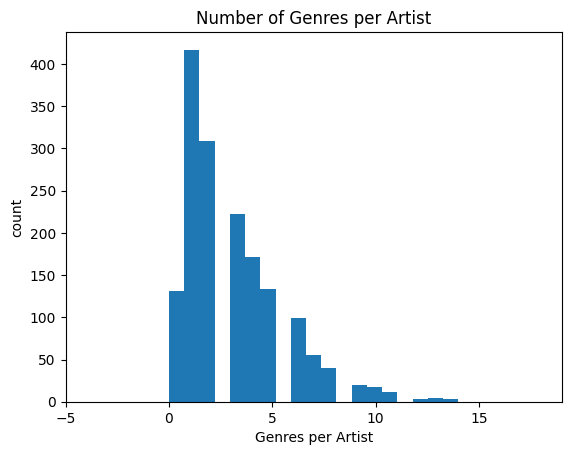

In [49]:

data = genres_per_artist

# fixed bin size
bins = np.linspace(math.ceil(min(data)), 
                   math.floor(max(data)),
                   20) # fixed number of bins

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=1)
plt.title('Number of Genres per Artist')
plt.xlabel('Genres per Artist')
plt.ylabel('count')

plt.show()

In [ ]:
# WTAF I cannot deal with 14 genres

# Big Note

__Well what do I do with a class once I have it?__

I think maybe I should just work with the data in a single table?
But it's hard to because I don't know what the data model should be.

### Thoughts on Data Schema and Metrics

__Genre Issue:__
- Where does it come from?
    - Genre can come from artist or album
    - If it's on the album then get it from the album (album has genre but sometimes it's null)
    - If it's artist level genre, then how can you blend genres across artists?
        - Rank most common genre
        - Rank most common genre, favoring first artist
        - Rank most common genre, favoring first genre order
        - Filter for top 3 genres, match all of them
        - Generate list by taking top genre from each artist then using those as the genre list, or expand to include all genres.
        - If the genre orders match, then genre should remain in that order placement (I don't actually like that)
- How to narrow down from a single list of genres
    - Take first genre
    - Merge first and second genre
    - Second Genre (for hierarchy)
    - Third Genre (for hierarchy)
- Should I just look up genre from another source?
- I need to assign the genre to each track because artists have their own genres, separate from tracks and albums.

__Artist Issue:__
- Who even is the artist if there are multiple artists listed?
    - Take first artist (best for analytics)??
    - Merge first and second artist
    - Second Artist (for hierarchy)
    - Third Artist (for hierarchy)

### Metrics

Well what do you want?
- streams over time
- most streamed artist
- most streamed album
- most streamed genre
- distribution of artist popularity
- distibution of track popularity
- genre streams over time
- streams
- which artists have the most diverse album genres
- most listened to album
- average song length you listen to?
- do you often listen to the whole song?
- do you often listen to a whole album?

__Issues with Data Model__

There seem to be so many different ways tom combine the following objects:
- stream
- track
- artist
- album
- playlist

Everything is relational, it depends on the question you are asking that determines the data needed.

The Spotify API tries to give enough data for what you need, but not give you everything.

__Data Model__
- stream
- track 1:many stream
- artist many:many track
- album 1:1 track
- playlist 1

__Alternate Data Model__
- album
- artist many:many album

### What do users do?
- They listen to tracks
- tracks have albums
- albums have artists
- tracks have an artist and a feature(s) when they are singles.
    - QA Note: Do the artists on single albums exactly match the artist on the track?
- tracks have collaborators when they aren't
- If the album is an anthology, the artist on the track won't match the artist on the album
    - QA Note: How often do track artists not match album artists
 
- Why does it matter what album the track is on?
    - Most streamed album metric
    - Did you stream the whole album in a row
    - What percentage of the album did you stream in a day

# Track Object

### Helpers

In [ ]:
subset = dict((k, result[k]) for k in ('id', 'name', 'duration_ms', 'popularity', 'disc_number', 'track_number', 'explicit', 'type'))


result['album']
result['album']['album_type']
result['album']['id']
result['album']['name']
result['album']['release_date']
result['album']['release_date_precision']
result['album']['total_tracks']
result['album']['type']

result['artists']
result['artists'][artist_order]['name']
result['artists'][artist_order]['id']
result['artists'][artist_order]['type']

result['disc_number']
result['track_number']
result['duration_ms']
result['explicit']
result['id']
result['name']
result['popularity']
result['type']

## Class

In [97]:
class track:
    def __init__(self, id):
        self.id = id
        self.data = sp.track(id)
        self.album = sp.album(self.data['album']['id'])

    def __repr__(self):
        return '"{}" by {}'.format(self.data['name'],self.data['artists'][0]['name'])


In [98]:
my_track = track('6JjSoJ2laV4ZbKNb9nybvh')

In [107]:
my_track.album#['genres']

{'album_type': 'single',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7tm9Tuc70geXOOyKhtZHIj'},
   'href': 'https://api.spotify.com/v1/artists/7tm9Tuc70geXOOyKhtZHIj',
   'id': '7tm9Tuc70geXOOyKhtZHIj',
   'name': 'Chris Lorenzo',
   'type': 'artist',
   'uri': 'spotify:artist:7tm9Tuc70geXOOyKhtZHIj'},
  {'external_urls': {'spotify': 'https://open.spotify.com/artist/1AHswQqsDNmu1xaE8KpBne'},
   'href': 'https://api.spotify.com/v1/artists/1AHswQqsDNmu1xaE8KpBne',
   'id': '1AHswQqsDNmu1xaE8KpBne',
   'name': 'COBRAH',
   'type': 'artist',
   'uri': 'spotify:artist:1AHswQqsDNmu1xaE8KpBne'}],
 'available_markets': ['AR',
  'AU',
  'AT',
  'BE',
  'BO',
  'BR',
  'BG',
  'CA',
  'CL',
  'CO',
  'CR',
  'CY',
  'CZ',
  'DK',
  'DO',
  'DE',
  'EC',
  'EE',
  'SV',
  'FI',
  'FR',
  'GR',
  'GT',
  'HN',
  'HK',
  'HU',
  'IS',
  'IE',
  'IT',
  'LV',
  'LT',
  'LU',
  'MY',
  'MT',
  'MX',
  'NL',
  'NZ',
  'NI',
  'NO',
  'PA',
  'PY',
  'PE',
  'PH',
  'PL',

In [105]:
list(my_track.album)

['album_type',
 'artists',
 'available_markets',
 'copyrights',
 'external_ids',
 'external_urls',
 'genres',
 'href',
 'id',
 'images',
 'label',
 'name',
 'popularity',
 'release_date',
 'release_date_precision',
 'total_tracks',
 'tracks',
 'type',
 'uri']

In [89]:
print(my_track)

"MAMI" by Chris Lorenzo


In [91]:
result['type']

'track'

# Issues

Recently played isn't returning records after a milisecond time stamp, I think it works more on a 12hr basis. Probably best to call this a couple or times per day

# Archive

### Old Updatinator

In [29]:
def get_artist_data(artists):
    list_fraction = math.ceil(len(artists) / 50)
    sp = spotify_terminal()
    iteration = 0
    final = {'artists': []}
    
    for artist_group in np.array_split(artists, list_fraction):
        artist_group = artist_group.tolist()
        result = sp.call_api(artist_group,'artists')
        if result.status_code != 200:
            print('bad call on iteration: {}'.format(iteration))
            print('    status code: {}'.format(result.status_code))
            break
        final['artists'].extend(result.json()['artists'])
        # print(iteration)
        iteration += 1
    return final

def append_new_artist_data(new_artist_data['artists']):
    # Opening JSON file
    with open('data_tables/artist_data.json', 'r') as openfile:
        # Reading from json file
        json_object = json.load(openfile)
    json_object['artists'].extend(new_artist_data)
    json_final = json.dumps(json_object, indent=4)
    with open("data_tables/artist_data.json", "w") as outfile:
        outfile.write(json_final)

### New API Trial

In [31]:
sp = spotify_terminal()

In [32]:
print(sp)

initialized at: 20231021_10_57_05


In [33]:
r = sp.call_api(['6wsqVwoiVH2kde4k4KKAFU','2wGSgTmgSF3xjRrHkTc25R'],'audio-features')

NameError: name 'headers' is not defined

In [160]:
r.json()

{'audio_features': [{'danceability': 0.927,
   'energy': 0.619,
   'key': 5,
   'loudness': -4.441,
   'mode': 0,
   'speechiness': 0.0539,
   'acousticness': 0.0186,
   'instrumentalness': 0,
   'liveness': 0.104,
   'valence': 0.817,
   'tempo': 117.995,
   'type': 'audio_features',
   'id': '6wsqVwoiVH2kde4k4KKAFU',
   'uri': 'spotify:track:6wsqVwoiVH2kde4k4KKAFU',
   'track_href': 'https://api.spotify.com/v1/tracks/6wsqVwoiVH2kde4k4KKAFU',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6wsqVwoiVH2kde4k4KKAFU',
   'duration_ms': 211582,
   'time_signature': 4},
  {'danceability': 0.802,
   'energy': 0.785,
   'key': 9,
   'loudness': -4.781,
   'mode': 1,
   'speechiness': 0.207,
   'acousticness': 0.14,
   'instrumentalness': 0,
   'liveness': 0.123,
   'valence': 0.435,
   'tempo': 99.998,
   'type': 'audio_features',
   'id': '2wGSgTmgSF3xjRrHkTc25R',
   'uri': 'spotify:track:2wGSgTmgSF3xjRrHkTc25R',
   'track_href': 'https://api.spotify.com/v1/tracks/2wGSgTmgSF3xj

In [161]:
t = sp.call_api('36QJpDe2go2KgaRleHCDTp','artists')

In [162]:
t.json()

{'external_urls': {'spotify': 'https://open.spotify.com/artist/36QJpDe2go2KgaRleHCDTp'},
 'followers': {'href': None, 'total': 13785152},
 'genres': ['album rock', 'classic rock', 'hard rock', 'rock'],
 'href': 'https://api.spotify.com/v1/artists/36QJpDe2go2KgaRleHCDTp',
 'id': '36QJpDe2go2KgaRleHCDTp',
 'images': [{'height': 600,
   'url': 'https://i.scdn.co/image/207803ce008388d3427a685254f9de6a8f61dc2e',
   'width': 600},
  {'height': 200,
   'url': 'https://i.scdn.co/image/b0248a44865493e6a03832aa89854ada16ff07a8',
   'width': 200},
  {'height': 64,
   'url': 'https://i.scdn.co/image/16eb3cdae0d824b520ac17710e943a99d3ef6602',
   'width': 64}],
 'name': 'Led Zeppelin',
 'popularity': 75,
 'type': 'artist',
 'uri': 'spotify:artist:36QJpDe2go2KgaRleHCDTp'}

In [ ]:
# 6wsqVwoiVH2kde4k4KKAFU I Know
# 2wGSgTmgSF3xjRrHkTc25R Hate it or love it

### Read and Write to JSON

In [ ]:
import json
 
# Data to be written
dictionary = {
    "name": "sathiyajith",
    "rollno": 56,
    "cgpa": 8.6,
    "phonenumber": "9976770500"
}
 
# Serializing json
json_object = json.dumps(dictionary, indent=4)
 
# Writing to sample.json
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
import json
 
# Opening JSON file
with open('sample.json', 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)
 
print(json_object)
print(type(json_object))

### get all artists from streaming history

In [94]:
result_list = []
iteration = 0
start = datetime.now()
for track in streaming_data:
    iteration += 1
    artist_name = track['artistName']
    # track_name = track['trackName']
    # end_time = track['endTime']
    # ms_played = track['msPlayed']
    if artist_name not in result_list:
        result_list.append(artist_name)

In [ ]:
podcasts = ['My Brother, My Brother And Me',
 'The Empty Bowl',
 'Marketplace',
 'The Always Sunny Podcast',
 'The Besties',
 'This Is Important',
 'SmartLess',
 'The Journal.',
 'Whiskey Ginger with Andrew Santino',
 'Code Switch']

### Parse items old

In [ ]:
###
# runs through the results of recently played and flattens the dictionary
# returns a cleaned dictionary of recently played
###
def parse_recently_played(recently_played_item):
    result = recently_played_item['track']
    subset = dict((k, result[k]) for k in ('id', 'name', 'duration_ms', 'popularity', 'disc_number', 'track_number', 'explicit', 'type'))
    subset['album_id'] = result['album']['id']
    subset['artist_id'] = result['artists'][0]['id']
    subset['artist_count'] = len(result['artists'])
    subset['played_at'] = recently_played_item['played_at']
    return subset

### Datetime handling

In [26]:
utc = datetime.strptime(current_max_played, "%Y-%m-%dT%H:%M:%S.%fZ")
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
utc = utc.replace(tzinfo=from_zone)
local = utc.astimezone(to_zone)
local_unix = int(time.mktime(local.timetuple())*1000)

### List Json File Names

In [16]:
path = "C://Users//Brian//Documents//python//spotify//MyData//"
dir_list = os.listdir(path)
print(dir_list)

['DuoNewFamily.json', 'Follow.json', 'Identifiers.json', 'Inferences.json', 'Marquee.json', 'Payments.json', 'Playlist1.json', 'Read_Me_First.pdf', 'SearchQueries.json', 'StreamingHistory0.json', 'UserAddress.json', 'Userdata.json', 'YourLibrary.json']


In [129]:
# Get the list of all files and directories
path = "C://Users//Brian//Documents//python//spotify//MyData//"
spotify_file_list = os.listdir(path)

# prints all files
for i in spotify_file_list:
    print(i.replace('.json', ''))

DuoNewFamily
Follow
Identifiers
Inferences
Marquee
Payments
Playlist1
Read_Me_First.pdf
SearchQueries
StreamingHistory0
UserAddress
Userdata
YourLibrary


### Simple Query From Spotipy Docs

In [6]:
scope = "user-library-read"

results = sp.current_user_saved_tracks()
for idx, item in enumerate(results['items']):
    track = item['track']
    print(idx, track['artists'][0]['name'], " – ", track['name'])

0 Slothrust  –  Pony
1 The Steeldrivers  –  East Kentucky Home
2 Norman Greenbaum  –  Spirit in the Sky
3 Redbone  –  Come and Get Your Love (Rerecorded Version)
4 Blue Swede  –  Hooked On A Feeling
5 Rupert Holmes  –  Escape (The Pina Colada Song)
6 Plague Vendor  –  Ox Blood
7 Art Tatum  –  Blue Skies
8 The Dillards  –  Dooley
9 Matroda  –  Gimme Some Keys
10 FJAAK  –  Plan of Escape
11 Chris Lorenzo  –  MAMI
12 Dreamville  –  Ma Boy
13 Ethereal  –  Beef
14 Freddie Gibbs  –  Couldn’t Be Done (feat. Kelly Price)
15 Quindon Tarver  –  Everybody's Free (To Wear Sunscreen)
16 Freddie Gibbs  –  Something to Rap About (feat. Tyler, The Creator)
17 Freddie Gibbs  –  Dark Hearted
18 Freddie Gibbs  –  PYS (feat. DJ Paul)
19 Freddie Gibbs  –  Feel No Pain (feat. Anderson .Paak & Raekwon)


### Playlist Info

In [ ]:
# print information about playlist names and IDs
# print(print_playlist_names(user_id))

def print_playlist_names(user_id):
    playlists = sp.user_playlists(user_id)
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
        


# Read JSON File Version

def get_playlist_data_old():
    playlist_data = get_json_from_file('Playlist1')['playlists']
    print('Number of playlists: {}'.format(len(playlist_data)))
    print('')
    print('List Playlist Names:')
    list_index = 0
    for i in playlist_data:
        print(i['name'],'index:',list_index)
        list_index += 1
    return playlist_data

In [111]:
playlists_data = get_playlist_data()

playlists_data[2]

Number of playlists: 42

List Playlist Names:
My recommendation playlist index: 0
Happy Birthday Mama! index: 1
Liked em index: 2
Listen List index: 3
Love songs index: 4
Karaoke Mix index: 5
Wedding index: 6
Dancing index: 7
Bacci Boys index: 8
Chilll index: 9
Summah index: 10
Funky index: 11
Random New index: 12
eclectric index: 13
Persian index: 14
Easy Listening index: 15
For My Love index: 16
nothiing index: 17
My Shazam Tracks index: 18
Pity Party index: 19
nate index: 20
you no index: 21
scRAP it index: 22
"Psychadelic" "Rock" index: 23
Pure Reggae Starbucks CD index: 24
Afro Cuban index: 25
FUN index: 26
Nold Scholl index: 27
House jammz index: 28
Glitch Hop index: 29
Yum Yum index: 30
Instrumentals index: 31
Ween index: 32
Folk index: 33
Jazz New index: 34
Rock Hard index: 35
Random discovered liked index: 36
Rock "Classics" index: 37
Lean on me index: 38
Rippitty Rap index: 39
Stoopid index: 40
Jazz Classic index: 41


{'name': 'Liked em',
 'lastModifiedDate': '2023-03-08',
 'items': [{'track': {'trackName': '151 Rum',
    'artistName': 'JID',
    'albumName': 'DiCaprio 2',
    'trackUri': 'spotify:track:22WV03i2lBbwNVCE1g671p'},
   'episode': None,
   'localTrack': None,
   'addedDate': '2023-02-07'},
  {'track': {'trackName': 'Two Tens (feat. Anderson .Paak)',
    'artistName': 'Cordae',
    'albumName': 'Two Tens (feat. Anderson .Paak)',
    'trackUri': 'spotify:track:6clDsO8HwhHEgJDDp88VdL'},
   'episode': None,
   'localTrack': None,
   'addedDate': '2023-02-07'},
  {'track': {'trackName': 'Ma Boy',
    'artistName': 'Dreamville',
    'albumName': 'Ma Boy',
    'trackUri': 'spotify:track:1kn9JsBWIw6qREhDWw0lKb'},
   'episode': None,
   'localTrack': None,
   'addedDate': '2023-02-07'},
  {'track': {'trackName': 'Eyes in the Back of My Head',
    'artistName': 'Katori Walker',
    'albumName': 'Eyes in the Back of My Head',
    'trackUri': 'spotify:track:5MrtQggewKtfSzs4akoaD2'},
   'episode': No

### Crap

In [5]:
get_most_recent_timestamp()

(1697629141000,
 datetime.datetime(2023, 10, 18, 7, 39, 1, 795000, tzinfo=tzlocal()))

In [66]:
print('BASIC ARTIST DATA')    
print(get_artist_data('1J6XFH9yaFImOmbaAWAx48'))
print('-----------------------------')
print('BASIC TRACK DATA')
print(get_track_data('7D5gkUVhkLbe5e8qG1NqcZ'))
print('-----------------------------')
print('BASIC ALBUM DATA')
print(get_album_data('4EAehCii5lZgeewct1LA5p'))

BASIC ARTIST DATA
{'id': '1J6XFH9yaFImOmbaAWAx48', 'name': 'R. Guru', 'genres': ['rain'], 'popularity': 53, 'followers': 460}
-----------------------------
BASIC TRACK DATA
{'id': '7D5gkUVhkLbe5e8qG1NqcZ', 'name': 'Brighter', 'duration_ms': 281084, 'popularity': 60, 'disc_number': 1, 'track_number': 1, 'explicit': False, 'type': 'track', 'album_id': '4EAehCii5lZgeewct1LA5p', 'artist_id': '5Pb27ujIyYb33zBqVysBkj', 'artist_count': 1}
-----------------------------
BASIC ALBUM DATA
{'id': '4EAehCii5lZgeewct1LA5p', 'name': 'Bloom', 'album_type': 'album', 'release_date': '2016-01-22', 'release_date_precision': 'day', 'popularity': 74, 'total_tracks': 11, 'genres': [], 'label': 'Sweat It Out', 'type': 'album'}
